In [2]:
import numpy as np
import time
import copy
import sys
sys.path.append('/home/ziniu.wzn/BayesCard')
import pandas as pd
import time
import bz2
import pickle
import logging
import ast

from DataPrepare.join_data_preparation import JoinDataPreparator
from Models.pgmpy_BN import Pgmpy_BN

In [ ]:
class BN_ensemble():
    """
    Several BNs combined one for each table.
    """

    def __init__(self, schema_graph, bns=dict()):
        self.schema_graph = schema_graph
        self.bns = bns
        self.cached_expectation_vals = dict()
        self.join_size = dict()
        self.join_prepare = None

    def add_BN(self, bn):
        self.bns[bn.table_name] = bn

    def save(self, path, compress=False):
        if compress:
            with bz2.BZ2File(path, 'wb') as f:
                pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
        else:
            with open(path, 'wb') as f:
                pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)

    def build_from_data(self, hdf_path, ensemble_path, max_table_data, sample_size=None, schema=None):
        """
        We will learn one BN each for each table in the schema graph
        Parameters
        ----------
        hdf_path: path to the folder that contain all pandas dataframe
        ensemble_path: path to save the learned BN ensemble
        max_table_data: max row per hdf file
        sample_size: How many sample to learning BN, if None then use the full data
        schema: containing all information about the graph and attributes
        """
        meta_data_path = hdf_path + '/meta_data.pkl'
        prep = JoinDataPreparator(meta_data_path, schema, max_table_data=max_table_data)
        self.join_prepare = prep

        if schema is not None:
            self.schema_graph = schema

        logger.info(f"Creating a BN for every relationship.")
        for relationship_obj in schema.relationships:
            logger.info(f"Learning BN for {relationship_obj.identifier}.")
            df_samples, meta_types, null_values, full_join_est = prep.generate_n_samples(
                sample_size, relationship_list=[relationship_obj.identifier])
            logger.debug(f"Requested {sample_size} samples and got {len(df_samples)}")
            bn = Pgmpy_BN()
            bn.build_from_data(df_samples)
            self.add_BN(bn)

        ensemble_path += '/ensemble_relationships_' + str(sample_size) + '.pkl'
        logger.info(f"Saving ensemble to {ensemble_path}")
        self.save(ensemble_path)

    def str_pattern_matching(self, s):
        # split the string "attr==value" to ('attr', '=', 'value')
        op = ['>', '<', '=']
        op_start = 0
        if len(s.split(' IN ')) != 1:
            s = s.split(' IN ')
            attr = s[0].strip()
            try:
                value = list(ast.literal_eval(s[1].strip()))
            except:
                value = s[1].strip()[1:][:-1].split(',')
            return attr, value

        for i in range(len(s)):
            if s[i] in op:
                op_start = i
                if i + 1 < len(s) and s[i + 1] in op:
                    op_end = i + 1
                else:
                    op_end = i
                break
        value = s[(op_end+1):]
        try:
            value = list(ast.literal_eval(s[1].strip()))
        except:
            value = value

        return s[:op_start], value

    def store_join_size(self):
        # Store the table size for each relation in the schema
        for relationship_obj in self.schema_graph.relationships:
            rel = relationship_obj.identifier
            self.join_size[rel] = self.join_prepare.size_estimate(relationship_list=[rel])[1]

    def get_full_join_size(self, rel):
        if type(rel) == list and len(rel) == 1:
            rel = rel[0]
        if type(rel) == str:
            return self.join_size[rel]
        else:
            return self.join_prepare.size_estimate(relationship_list=rel)[1]

    def naive_cardinality(self, query):
        # estimate the cardinality of given query
        select_tables = query.table_set
        conditions = query.table_where_condition_dict
        relations = query.relationship_set
        # reformulate them to Single_BN executable form
        p_estimate = 1
        for table_name in select_tables:
            if table_name in conditions:
                table_query = dict()
                for conditions in conditions[table_name]:
                    attr, val = self.str_pattern_matching(conditions)
                    attr = table_name + '.' + attr
                    table_query[attr] = val
                p = self.bns[table_name].infer_query(table_query, return_prob=True)
                p_estimate *= p[0]

        return p_estimate * self.get_full_join_size(list(relations))

In [ ]:
tic = time.time()
BN = Pgmpy_BN('dmv')
BN.build_from_data(data_to_use, algorithm="greedy", max_parents=4, ignore_cols=['id'], sample_size=100000)
print(time.time()-tic)

In [ ]:
BN.model = BN.model.to_junction_tree()

In [ ]:
import pickle
pickle.dump(BN.model, open('greedy', 'wb'), pickle.HIGHEST_PROTOCOL)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

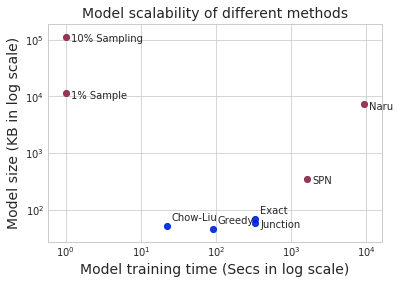

In [6]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
x = [22.13, 329, 90, 330, 1629, 9318, 1, 1]
y = [52, 69, 46, 58, 345, 7230, 11300, 113000]
types = ["Chow-Liu", "Exact", "Greedy", "Junction", "SPN", "Naru", "1% Sample", "10% Sampling"]
fig, ax = plt.subplots()
ax.scatter(x, y)

ax.set_xlabel('Model training time (Secs in log scale)', fontsize=14)
ax.set_ylabel('Model size (KB in log scale)', fontsize=14)
ax.set_title('Model scalability of different methods', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')


for i, txt in enumerate(types[0:4]):
    if txt == "Junction":
        xytext=(5,-5)
    else:
        xytext=(5,5)
    ax.annotate(txt, (x[i], y[i]), xytext=xytext, textcoords='offset points', fontsize=10)
    plt.scatter(x[i], y[i], color='blue', alpha=0.5)

for i, txt in enumerate(types[4:]):
    i += 4
    ax.annotate(txt, (x[i], y[i]), xytext=xytext, textcoords='offset points', fontsize=10)
    plt.scatter(x[i], y[i], color='red', alpha=0.5)